I've making this notebook while I am waiting for the data to be generated. 
If everything goes well, I will be able to use this notebook to analyze the data.

In [66]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# import seaborn as sns
from matplotlib.lines import Line2D
plt.rc('text', usetex=True)
import src.hyperparameters as hps
import src.kernel as kernel

from fvgp.gp import GP
from dask.distributed import Client

# Kernel vs Kernel plot

In [67]:
DATA_DIR = '../data/'
FILE_NAME = 'data_1960.csv'
MAT_SIZE = 100   # just to plot it 

In [68]:
data = pd.read_csv(DATA_DIR + FILE_NAME)
data.dropna(inplace = True)
x_data = data[['Latitude', 'Longitude', 'dt_float']].values
y_data = data['AverageTemperature'].values
# Extract a small subset of the data for testing on local machine
n_samples = MAT_SIZE
idx = np.random.choice(np.arange(x_data.shape[0]), n_samples, replace = False)
x_data = x_data[idx]
y_data = y_data[idx]


In [69]:
client = Client()

In [70]:
hyperpar_mix = hps.build_hps(1,1,3)
bounds_mix = hps.build_bounds(1,1,3)

# use the kernel defined in the src folder
gp_mix = GP(3, x_data, y_data, init_hyperparameters=hyperpar_mix, hyperparameter_bounds=bounds_mix, gp_kernel_function=kernel.custom_kernel_one_shot, gp2Scale=True, gp2Scale_dask_client=client, gp2Scale_batch_size=10)

In [71]:
gp_mix.train()

In [72]:
K_mix = gp_mix.K.toarray()

In [73]:
def l2_norm(x1, x2):
    return np.sqrt(np.sum((x1 - x2)**2))

def custom_kernel_no_period(x_data, x_data1, hyperparameters, obj):
    # copy-pasted from the source code, but with the period part removed
    N = x_data.shape[0]
    NN = x_data1.shape[0]
    K = np.empty([N, NN])
    for i in range(N):
        for j in range(i, NN):
            x1 = x_data[i]
            x2 = x_data1[j]
            n1 = 1
            n2 = 1
            D = 3  # input dimension
            SQRT2 = np.sqrt(2)          # no need to compute it every time

            centers = hyperparameters[:n1 * n2 * D].reshape(n1, n2, D)
            radii = hyperparameters[n1 * n2 * D:n1 * n2 * D + n2]
            amplitudes = hyperparameters[n1 * n2 * D + n2:n1 * n2 * D + 2 * n2]
            shape_parameters = hyperparameters[n1 * n2 * D + 2 * n2:n1 * n2 * D + 3 * n2]
            r = hyperparameters[-3]
            
            k_tilde = 0
            d = np.sqrt(np.sum((x1 - x2)**2))  # l2_norm(x1, x2)
            if d == 0:
                d = 1e-10                      # avoid log(0)
            if d < r:
                k_tilde = SQRT2 / (np.pi ** (1 / 3)) * (
                            3 * (d / r) ** 2 * np.log((d / r) / (1 + np.sqrt(1 - (d / r) ** 2))) + (
                                2 * (d / r) ** 2 + 1) * np.sqrt(1 - (d / r) ** 2))

            k_sparse = 0
            for ii in range(n1):
                for jj in range(n2):
                    x0 = centers[ii, jj]
                    r = radii[jj]
                    a = amplitudes[jj]
                    beta = shape_parameters[jj]
                    chi = 0
                    if r < np.sqrt(np.sum((x1 - x0)**2)):
                        chi = 1
                    k_sparse += a * np.exp(-1 * beta / (1 - np.sum((x1 - x0)**2) / r ** 2)) * chi * \
                                a * np.exp(-1 * beta / (1 - np.sum((x2 - x0)**2) / r ** 2)) * chi

            K[i, j] = k_tilde * k_sparse
            K[j, i] = K[i, j]
            
    return K

In [74]:
hyperpar_sparse = hps.build_hps(1,1,3)
bounds_sparse = hps.build_bounds(1,1,3)
# remove the last 2 hyperparameters
hyperpar_sparse = hyperpar_sparse[:-2]
bounds_sparse = bounds_sparse[:-2]

gp_sparse = GP(3, x_data, y_data, init_hyperparameters=hyperpar_sparse, hyperparameter_bounds=bounds_sparse, gp_kernel_function=custom_kernel_no_period, gp2Scale=True, gp2Scale_dask_client=client, gp2Scale_batch_size=10)

In [75]:
gp_sparse.train()

In [76]:
def periodic_kernel(x_data, x_data1, hyperparameters, obj):
    N = x_data.shape[0]
    NN = x_data1.shape[0]
    K = np.empty([N, NN])
    length_scale = hyperparameters[0]
    period = hyperparameters[1]
    for i in range(N):
        for j in range(i, NN):
            x1 = x_data[i]
            x2 = x_data1[j]
            d = np.sqrt(np.sum((x1 - x2)**2))
            K[i, j] = np.exp(-2 * np.sin(np.pi * d / period)**2 / length_scale**2)
            K[j, i] = K[i, j]
    return K

hyperpar_period = np.array([1, 1])
bounds_period = np.array([(1e-5, 1e2), (1e-5, 1e2)])

In [77]:
gp_period = GP(3, x_data, y_data, init_hyperparameters=hyperpar_period, hyperparameter_bounds=bounds_period, gp_kernel_function=periodic_kernel, gp2Scale=True, gp2Scale_dask_client=client, gp2Scale_batch_size=10)

In [78]:
gp_period.train()

In [79]:
# Save all the hps for later

# hps_sparse = gp_sparse.hyperparameters
# hps_gaus = gp_period.hyperparameters
# hps_mix = gp_mix.hyperparameters
# np.save('hps_sparse.npy', hps_sparse)
# np.save('hps_gaus.npy', hps_gaus)
# np.save('hps_mix.npy', hps_mix)

In [80]:
def compute_sparity(K):
    non_zero = np.count_nonzero(K)
    total = K.shape[0] * K.shape[1]
    return round(non_zero/total*100, 2)
print(f"Sparse: {compute_sparity(gp_sparse.K.toarray())}")
print(f"periodic: {compute_sparity(gp_period.K.toarray())}")
print(f"Mix: {compute_sparity(gp_mix.K.toarray())}")

Sparse: 1.0
periodic: 100.0
Mix: 11.2


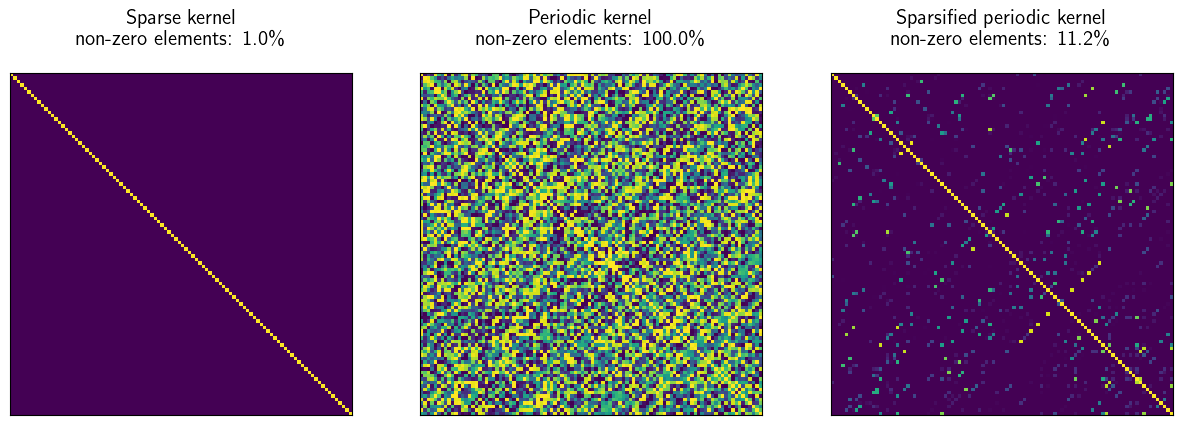

In [90]:
# make a global plot 

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(gp_sparse.K.toarray())
axs[0].set_title(f'Sparse kernel\nnon-zero elements: {compute_sparity(gp_sparse.K.toarray())}\%', pad=20, fontsize=15, fontweight='bold')
axs[0].set_xticks([])
axs[0].set_yticks([])

axs[1].imshow(gp_period.K.toarray())
axs[1].set_title(f'Periodic kernel\nnon-zero elements: {compute_sparity(gp_period.K.toarray())}\%', pad=20, fontsize=15, fontweight='bold')
axs[1].set_xticks([])
axs[1].set_yticks([])

axs[2].imshow(gp_mix.K.toarray())
axs[2].set_title(f'Sparsified periodic kernel\nnon-zero elements: {compute_sparity(gp_mix.K.toarray())}\%', pad=20, fontsize=15, fontweight='bold')
axs[2].set_xticks([])
axs[2].set_yticks([])

# plt.tight_layout()
plt.show()

# save the plot as a svg file
fig.savefig('kernel_comparison.svg', format='svg', dpi=1200, bbox_inches='tight')


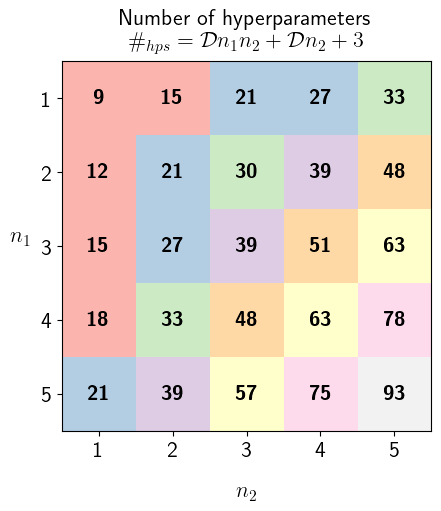

In [82]:
#copy-pasted from the other notebook: 
def count_hps(n1, n2, D=3):
    return D*n1*n2 + 3*n2 + 3
n_to_show = 5
matrix = np.zeros((n_to_show, n_to_show))
for i in range(n_to_show):
    for j in range(n_to_show):
        matrix[i, j] = count_hps(i+1, j+1, D= 3)

# make the plot: 
# plt.imshow(matrix, cmap='coolwarm')
# plt.imshow(matrix, cmap='Wistia')
plt.imshow(matrix, cmap='Pastel1')
# Add text annotations
for i in range(n_to_show):
    for j in range(n_to_show):
        lab = int(matrix[i, j])
        lab = "\\textbf{" + str(lab) + "}"
        plt.text(j, i, lab, ha='center', va='center', color='black', fontsize=15)
# Set ticks for x and y axes
plt.xticks(np.arange(n_to_show), np.arange(1, n_to_show+1), fontsize=16)
plt.yticks(np.arange(n_to_show), np.arange(1, n_to_show+1), fontsize=16)

plt.xlabel('$n_2$', rotation=0, labelpad=15, fontsize=16, fontweight='bold')
plt.ylabel('$n_1$', rotation=0, labelpad=15, fontsize=16, fontweight='bold')
plt.title('Number of hyperparameters\n$\#_{hps}=\mathcal{D}n_1n_2 + \mathcal{D}n_2 + 3$', fontsize=16, fontweight='bold', pad=10)

# save the plot as a svg file
plt.savefig('hps_count.svg', format='svg', dpi=1200, bbox_inches='tight')
plt.show()



## Bubble plots

In [83]:
# Load the data
fit = pd.read_csv('fit.csv')

In [84]:
def better_out(n):
    # display time in minutes
    return str(round(n/60,2))

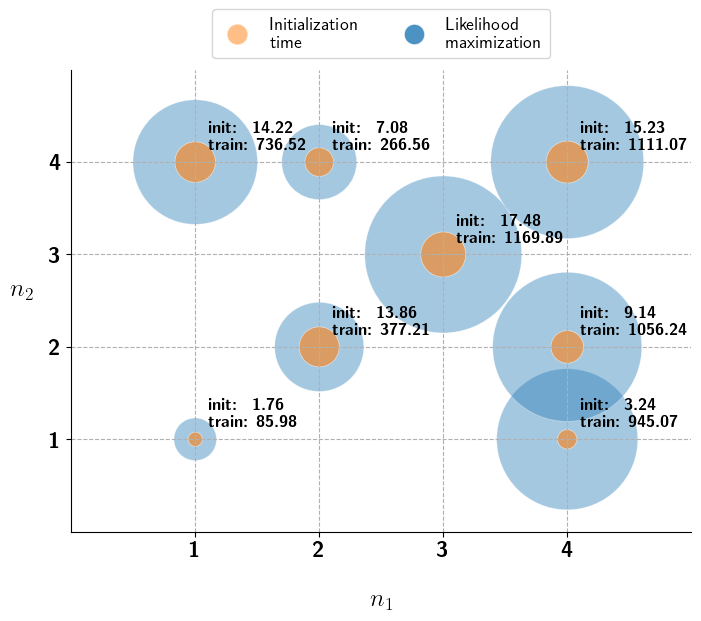

In [85]:
# Create the bubble plot
plt.figure(figsize=(8, 6))

palette = ['tab:blue', 'tab:orange']

plt.scatter(fit['n1'], fit['n2'], s=fit['train']/5.5, alpha=0.4, label='train', edgecolors='w', linewidth=0.5, color=palette[0])
plt.scatter(fit['n1'], fit['n2'], s=fit['init'], alpha=0.6, label='init', edgecolors='w', linewidth=0.5, color=palette[1])

plt.xlabel('$n_1$', rotation=0, labelpad=20, fontsize=18, fontweight='bold')
plt.ylabel('$n_2$', rotation=0, labelpad=20, fontsize=18, fontweight='bold')
# plt.title('Time spent to init GP object and optimizing log-likelihood\nfor various$n_1$ vs $n_2$', fontsize=16, fontweight='bold', pad=25)

# Annotate each point with the values of 'init' and 'train' outside the bubbles
# TODO --> Comment this part if needed
for i in range(len(fit)):
    string = "\\textbf{init: \\  " + better_out(fit['init'][i] ) + "}\n\\textbf{train: " + better_out(fit['train'][i]) + "}"
    plt.text(fit['n1'][i] + 0.1, fit['n2'][i] + 0.1, string,
             fontsize=12, ha='left', va='bottom', fontweight='bold')
    
# Create custom legend
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Initialization\ntime', markerfacecolor=palette[1],
                          markersize=15, alpha=0.5),
                   Line2D([0], [0], marker='o', color='w', label='Likelihood\nmaximization', markerfacecolor=palette[0],
                         markersize=15, alpha=0.8)]
# Position the legend at the bottom of the plot
plt.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 1.15), fontsize=13, ncol=2)

plt.xlim(0, 5)
plt.ylim(0, 5)

plt.xticks(ticks=[1, 2, 3, 4], labels=['\\textbf{1}', '\\textbf{2}', '\\textbf{3}', '\\textbf{4}'], fontsize=16, fontweight='bold')
plt.yticks(ticks=[1, 2, 3, 4], labels=['\\textbf{1}', '\\textbf{2}', '\\textbf{3}', '\\textbf{4}'], fontsize=16, fontweight='bold')

plt.grid(True, which='major', linestyle='--')
plt.minorticks_off() 



# remove the borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
# save the plot as a svg file
plt.savefig('initialization.svg', format='svg', dpi=1200, bbox_inches='tight')

plt.show()


In [86]:
# Load the data
infer = pd.read_csv('infer.csv')
infer['rmse'] = np.sqrt(infer['mse'])

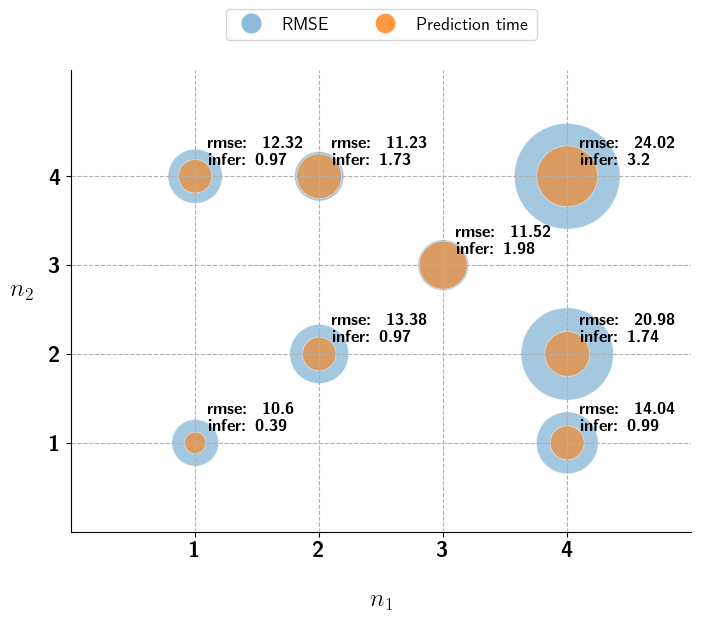

In [87]:
# Create the bubble plot
plt.figure(figsize=(8, 6))

palette = ['tab:orange', 'tab:blue']

plt.scatter(infer['n1'], infer['n2'], s=10*infer['rmse']**2, alpha=0.4, label='init', edgecolors='w', linewidth=0.5, color=palette[1])
plt.scatter(infer['n1'], infer['n2'], s=infer['infer']*10, alpha=0.6, label='infer', edgecolors='w', linewidth=0.5, color=palette[0])

plt.xlabel('$n_1$', rotation=0, labelpad=20, fontsize=18, fontweight='bold')
plt.ylabel('$n_2$', rotation=0, labelpad=20, fontsize=18, fontweight='bold')
# plt.title('Time spent to init GP object and optimizing log-likelihood\nfor various$n_1$ vs $n_2$', fontsize=16, fontweight='bold', pad=25)

# Annotate each point with the values of 'init' and 'train' outside the bubbles
# TODO --> Comment this part if needed
for i in range(len(fit)):
    string = "\\textbf{rmse: \\  " + str(round(infer['rmse'][i],2) ) + "}\n\\textbf{infer: " + better_out(infer['infer'][i]) + "}"
    plt.text(infer['n1'][i] + 0.1, infer['n2'][i] + 0.1, string,
             fontsize=12, ha='left', va='bottom', fontweight='bold')
    
# Create custom legend
legend_elements = [Line2D([0], [0], marker='o', color='w', label='RMSE', markerfacecolor=palette[1],
                          markersize=15, alpha=0.5),
                   Line2D([0], [0], marker='o', color='w', label='Prediction time', markerfacecolor=palette[0],
                         markersize=15, alpha=0.8)]
# Position the legend outside the plot
plt.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 1.15), fontsize=13, ncol=2)

plt.xlim(0, 5)
plt.ylim(0, 5.2)

plt.xticks(ticks=[1, 2, 3, 4], labels=['\\textbf{1}', '\\textbf{2}', '\\textbf{3}', '\\textbf{4}'], fontsize=16, fontweight='bold')
plt.yticks(ticks=[1, 2, 3, 4], labels=['\\textbf{1}', '\\textbf{2}', '\\textbf{3}', '\\textbf{4}'], fontsize=16, fontweight='bold')

plt.grid(True, which='major', linestyle='--')
plt.minorticks_off() 

# remove the borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
# save the plot as a svg file
plt.savefig('hps_comparison.svg', format='svg', dpi=1200, bbox_inches='tight')

plt.show()

Same as above, but without label 

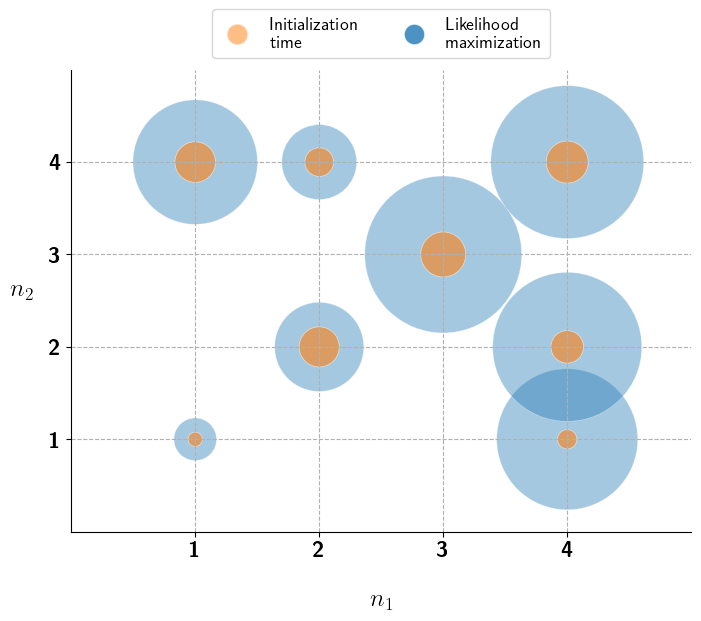

In [88]:
# Create the bubble plot
plt.figure(figsize=(8, 6))

palette = ['tab:blue', 'tab:orange']

plt.scatter(fit['n1'], fit['n2'], s=fit['train']/5.5, alpha=0.4, label='train', edgecolors='w', linewidth=0.5, color=palette[0])
plt.scatter(fit['n1'], fit['n2'], s=fit['init'], alpha=0.6, label='init', edgecolors='w', linewidth=0.5, color=palette[1])

plt.xlabel('$n_1$', rotation=0, labelpad=20, fontsize=18, fontweight='bold')
plt.ylabel('$n_2$', rotation=0, labelpad=20, fontsize=18, fontweight='bold')
# plt.title('Time spent to init GP object and optimizing log-likelihood\nfor various$n_1$ vs $n_2$', fontsize=16, fontweight='bold', pad=25)

# for i in range(len(fit)):
#     string = "\\textbf{init: \\  " + better_out(fit['init'][i] ) + "}\n\\textbf{train: " + better_out(fit['train'][i]) + "}"
#     plt.text(fit['n1'][i] + 0.1, fit['n2'][i] + 0.1, string,
#             fontsize=12, ha='left', va='bottom', fontweight='bold')
    
# Create custom legend
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Initialization\ntime', markerfacecolor=palette[1],
                          markersize=15, alpha=0.5),
                   Line2D([0], [0], marker='o', color='w', label='Likelihood\nmaximization', markerfacecolor=palette[0],
                         markersize=15, alpha=0.8)]
# Position the legend at the bottom of the plot
plt.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 1.15), fontsize=13, ncol=2)

plt.xlim(0, 5)
plt.ylim(0, 5)

plt.xticks(ticks=[1, 2, 3, 4], labels=['\\textbf{1}', '\\textbf{2}', '\\textbf{3}', '\\textbf{4}'], fontsize=16, fontweight='bold')
plt.yticks(ticks=[1, 2, 3, 4], labels=['\\textbf{1}', '\\textbf{2}', '\\textbf{3}', '\\textbf{4}'], fontsize=16, fontweight='bold')

plt.grid(True, which='major', linestyle='--')
plt.minorticks_off() 



# remove the borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
# save the plot as a svg file
plt.savefig('initialization_nolab.svg', format='svg', dpi=1200, bbox_inches='tight')

plt.show()


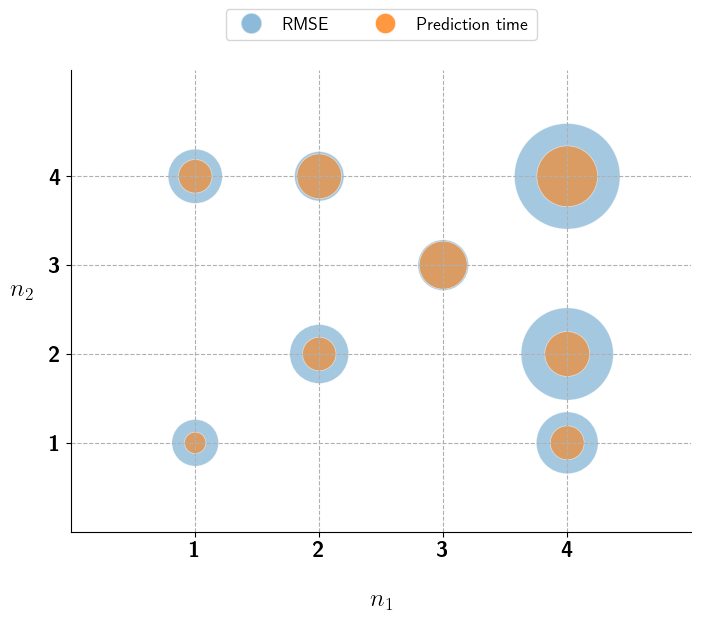

In [89]:
# Create the bubble plot
plt.figure(figsize=(8, 6))

palette = ['tab:orange', 'tab:blue']

plt.scatter(infer['n1'], infer['n2'], s=10*infer['rmse']**2, alpha=0.4, label='init', edgecolors='w', linewidth=0.5, color=palette[1])
plt.scatter(infer['n1'], infer['n2'], s=infer['infer']*10, alpha=0.6, label='infer', edgecolors='w', linewidth=0.5, color=palette[0])

plt.xlabel('$n_1$', rotation=0, labelpad=20, fontsize=18, fontweight='bold')
plt.ylabel('$n_2$', rotation=0, labelpad=20, fontsize=18, fontweight='bold')
# plt.title('Time spent to init GP object and optimizing log-likelihood\nfor various$n_1$ vs $n_2$', fontsize=16, fontweight='bold', pad=25)

# for i in range(len(fit)):
#     string = "\\textbf{rmse: \\  " + str(round(infer['rmse'][i],2) ) + "}\n\\textbf{infer: " + better_out(infer['infer'][i]) + "}"
#     plt.text(infer['n1'][i] + 0.1, infer['n2'][i] + 0.1, string,
#              fontsize=12, ha='left', va='bottom', fontweight='bold')
#     

# Create custom legend
legend_elements = [Line2D([0], [0], marker='o', color='w', label='RMSE', markerfacecolor=palette[1],
                          markersize=15, alpha=0.5),
                   Line2D([0], [0], marker='o', color='w', label='Prediction time', markerfacecolor=palette[0],
                         markersize=15, alpha=0.8)]
# Position the legend outside the plot
plt.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 1.15), fontsize=13, ncol=2)

plt.xlim(0, 5)
plt.ylim(0, 5.2)

plt.xticks(ticks=[1, 2, 3, 4], labels=['\\textbf{1}', '\\textbf{2}', '\\textbf{3}', '\\textbf{4}'], fontsize=16, fontweight='bold')
plt.yticks(ticks=[1, 2, 3, 4], labels=['\\textbf{1}', '\\textbf{2}', '\\textbf{3}', '\\textbf{4}'], fontsize=16, fontweight='bold')

plt.grid(True, which='major', linestyle='--')
plt.minorticks_off() 

# remove the borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
# save the plot as a svg file
plt.savefig('hps_comparison_nolab.svg', format='svg', dpi=1200, bbox_inches='tight')

plt.show()

In [104]:
df = fit
df['infer'] = infer['infer']
df['rmse'] = infer['rmse']
df

,n1,n2,init,train,infer,rmse
0,1,1,105.34,5159.07,23.53,10.598113
1,1,4,852.95,44191.26,58.28,12.320714
2,2,2,831.74,22632.68,57.96,13.381704
3,2,4,425.02,15993.59,103.56,11.225863
4,3,3,1048.93,70193.17,119.09,11.517812
5,4,1,194.45,56704.49,59.43,14.040655
6,4,2,548.55,63374.39,104.31,20.982135
7,4,4,914.06,66663.95,192.03,24.017077
